# Task - 1:
Repeat all the task from worksheet - 5 but, try to improve the model from last week with same dataset.

• Use Data Augmentation to increase the number of training image.

• Use deeper model with BN and DropOut layer as presented above.

• Understand the Model Summary and Training Behavior.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train_df = "/content/drive/MyDrive/6CS012 - Artificial Intelligence and Machine Learning/Week 5/FruitinAmazon/train"
test_df = "/content/drive/MyDrive/6CS012 - Artificial Intelligence and Machine Learning/Week 5/FruitinAmazon/test"

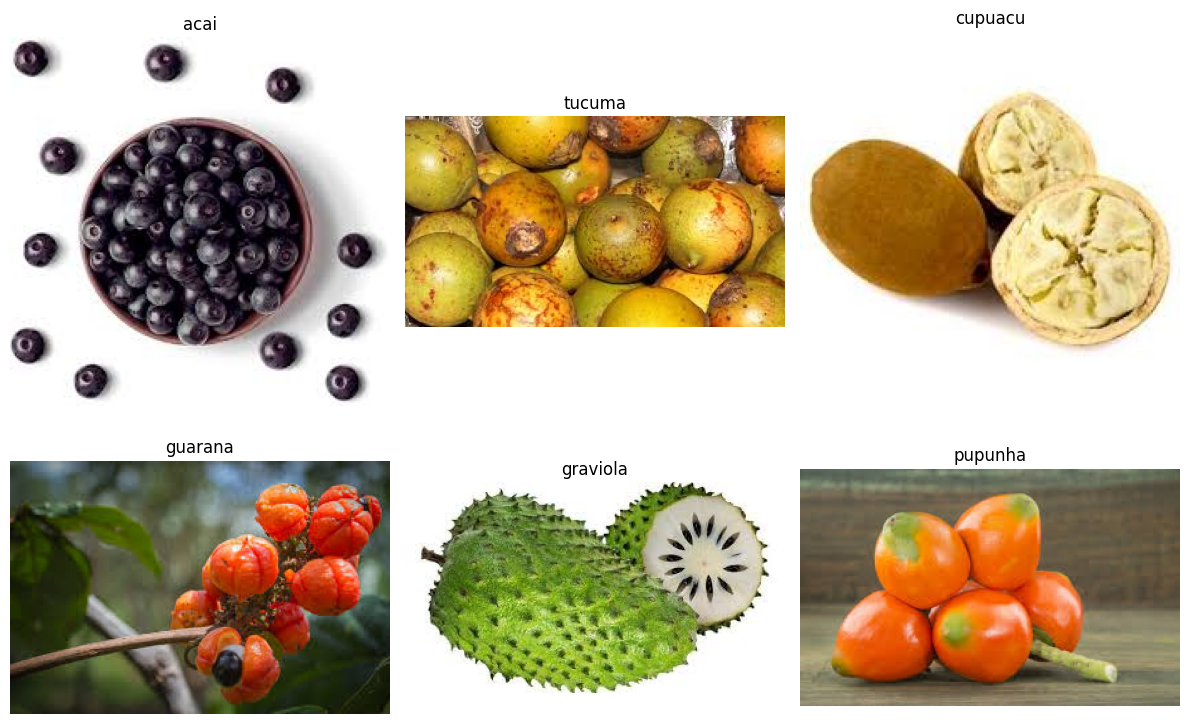

In [5]:
#List of class directories
class_dirs = os.listdir(train_df)

#List to hold the images and labels
images = []
labels = []

for class_name in class_dirs:
  class_path = os.path.join(train_df, class_name)
  image_files = os.listdir(class_path)

  #Select a random image from each class
  random_image = random.choice(image_files)
  random_image_path = os.path.join(class_path, random_image)

  images.append(mpimg.imread(random_image_path))
  labels.append(class_name)

#Plot the images in 2 rows, divide the columns accordingly
fig, axes = plt.subplots(nrows=2, ncols=len(class_dirs)//2, figsize=(12, 8))
axes = axes.ravel()

for i in range(len(images)):
  ax = axes[i]
  ax.imshow(images[i])
  ax.set_title(labels[i])
  ax.axis('off')

plt.tight_layout()
plt.show()

2. Check for Corrupted Image: Write a script that verifies whether the image in the train
directory are valid. If any corrupted images are found, the script must remove the image from
the directory and print the message which image have been removed, if none found print ”No
Corrupted Images Found.”

In [6]:
#List to store path to corrupted images
corrupted_images = []

#Iterate through each class directory
for class_name in class_dirs:
  class_path = os.path.join(train_df, class_name)
  #Ensure it's a directory
  if os.path.isdir(class_path):
      #Iterate through all image files in the class directory
      for image_name in os.listdir(class_path):
          image_path = os.path.join(class_path, image_name)

          #Check if the file is an image (assuming common formats)
          if image_path.lower().endswith(('jpg', 'jpeg', 'png', 'gif')):
              try:
                  #Try to open the image
                  with Image.open(image_path) as img:
                      img.verify()  # verify the image is not corrupted
                      width, height = img.size

                      #Print the height
              except (IOError, SyntaxError) as e:
                  #If an error occurs, it means the image is corrupted
                  corrupted_images.append(image_path)
                  os.remove(image_path)  # remove the corrupted image
                  print(f"Removed corrupted image: {image_path}")

#Check if any corrupted images were found
if not corrupted_images:
    print("No corrupted images found.")

No corrupted images found.


In [8]:
#Data preparation
#Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,  #Normalize pixel values to [0, 1]
    validation_split=0.2
)

#Create training and validation data generators
train_generator = datagen.flow_from_directory(
    train_df,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='training',
    seed=1337
)

#Create a separate ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Create validation generator without augmentations
validation_generator = val_datagen.flow_from_directory(
    train_df,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False  #Important: Keep order consistent
)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [9]:
image_size = (128, 128)
batch_size = 64

In [10]:
def build_improved_model(input_shape=(128, 128, 3), num_classes=6):
    model = keras.Sequential([
        #Data augmentation and rescaling
        layers.Input(shape=input_shape),

        #First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        #Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        #Third Convolutional Block
        layers.Conv2D(128, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        #Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(256, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        #Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [11]:
#Create and compile model
model = build_improved_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 13s/step - accuracy: 0.1296 - loss: 2.5228 - val_accuracy: 0.1667 - val_loss: 2.5914
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step - accuracy: 0.3796 - loss: 1.6606 - val_accuracy: 0.1667 - val_loss: 2.3454
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step - accuracy: 0.4861 - loss: 1.5976 - val_accuracy: 0.1111 - val_loss: 1.9237
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step - accuracy: 0.3287 - loss: 1.6382 - val_accuracy: 0.1667 - val_loss: 1.9137
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.5041 - loss: 1.4961 - val_accuracy: 0.1667 - val_loss: 2.0197
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - accuracy: 0.5231 - loss: 1.3264 - val_accuracy: 0.1667 - val_loss: 2.1387
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step - accuracy: 0.4583 - loss: 1.3623 - val_accuracy: 0.1667 - val_loss: 2.2168


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_df,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',
    seed=1337,
    shuffle=False
)

Found 30 images belonging to 6 classes.


In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1667 - loss: 1.9606
Test accuracy: 0.1667


In [15]:
test_generator_1 = test_datagen.flow_from_directory(
    test_df,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    seed=1337
)

Found 30 images belonging to 6 classes.


In [16]:
test_loss, test_acc = model.evaluate(test_generator_1)
print(f"Test accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1667 - loss: 1.9606
Test accuracy: 0.1667


# Task - 2:
• Implement transfer learning using a pre-trained model trained on ImageNet weights, freeze the layers of the model, and fit it only on the output layer to classify the fruits dataset.

• Evaluate the model’s performance and generate an inference output and classification report.

• Did the performance improved compared to training from scratch.

**Expected Deliverables:**

• Trained Model: A trained model with the frozen layers and fine-tuned output layer.

• Inference Output: Predicted class labels for the validation dataset.

• Classification Report: A detailed classification report showing the performance of the model for
each class.

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np

In [18]:
class_names = sorted(os.listdir(train_df))

In [19]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model except from block conv 5
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [20]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [21]:
#Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

#Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
#Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
#Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 7,610,886 (29.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [24]:
#Create training and validation data generators
train_generator = datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='training',
    seed=1337
)

#Create a separate ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Create validation generator without augmentations
validation_generator = val_datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False  # Important: Keep order consistent
)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [25]:
model.fit(train_generator, validation_data=validation_generator, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 49s 39s/step - accuracy: 0.2454 - loss: 7.7560 - val_accuracy: 0.1667 - val_loss: 3.1001
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - accuracy: 0.1487 - loss: 3.2077 - val_accuracy: 0.1667 - val_loss: 1.7785
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.0833 - loss: 2.5875 - val_accuracy: 0.1667 - val_loss: 1.8176
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1528 - loss: 1.8171 - val_accuracy: 0.1667 - val_loss: 1.7972
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.1539 - loss: 1.7972 - val_accuracy: 0.2778 - val_loss: 1.8046
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1528 - loss: 1.7976 - val_accuracy: 0.1667 - val_loss: 1.8329
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1019 - loss: 1.8481 - val_accuracy: 0.1667 - val_loss: 1.7884
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.1105 - loss: 1.7925 - val_accuracy: 0.1667 - val_loss: 1.7935
Epoch

# New Model
**Shape - 224**

In [26]:
train_generator_2 = datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='training',
    seed=1337
)

#Create a separate ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Create validation generator without augmentations
validation_generator_2 = val_datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False  #Important: Keep order consistent
)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [27]:
#Load pre-trained VGG16 model
base_model_224 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze all layers in the base model
for layer in base_model_224.layers:
    layer.trainable = False

#Add custom layers on top
x224 = base_model_224.output
x224 = GlobalAveragePooling2D()(x224)
x224 = Dense(1024, activation='relu')(x224)
predictions224 = Dense(len(class_names), activation='softmax')(x224)

#Create final model
model224 = Model(inputs=base_model_224.input, outputs=predictions224)

#Compile the model
model224.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#Display model summary
model224.summary()

#Train the model
history224 = model224.fit(
    train_generator_2,
    validation_data=validation_generator_2,
    epochs=15,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

#Evaluate the model
val_loss224, val_acc224 = model224.evaluate(validation_generator_2)
print(f"Validation Accuracy: {val_acc224:.4f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1539 - loss: 1.8758 - val_accuracy: 0.3333 - val_loss: 1.7404
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3565 - loss: 1.6943 - val_accuracy: 0.2222 - val_loss: 1.7010
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.2830 - loss: 1.6811 - val_accuracy: 0.4444 - val_loss: 1.6173
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3426 - loss: 1.6036 - val_accuracy: 0.4444 - val_loss: 1.5590
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.4421 - loss: 1.4765 - val_accuracy: 0.3333 - val_loss: 1.4869
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6296 - loss: 1.3002 - val_accuracy: 0.4444 - val_loss: 1.4566
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - accuracy: 0.5920 - loss: 1.2814 - val_accuracy: 0.5556 - val_loss: 1.3944
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.6591 - loss: 1.2076 - val_accuracy: 0.6667 - val_loss: 1.3130
Epoc

In [28]:
#Ensure the validation generator does NOT shuffle
validation_generator_2.shuffle = False

#Get true labels
true_labels = validation_generator_2.classes

#Get class labels in correct order
class_labels = list(validation_generator_2.class_indices.keys())

#Make predictions
pred_probs = model224.predict(validation_generator_2)

#Convert predictions to class labels
pred_labels = np.argmax(pred_probs, axis=1)

#Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
Classification Report
              precision    recall  f1-score   support

        acai       1.00      0.33      0.50         3
     cupuacu       0.43      1.00      0.60         3
    graviola       1.00      0.67      0.80         3
     guarana       0.67      0.67      0.67         3
     pupunha       0.33      0.33      0.33         3
      tucuma       0.50      0.33      0.40         3

    accuracy                           0.56        18
   macro avg       0.65      0.56      0.55        18
weighted avg       0.65      0.56      0.55        18



In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator_2 = test_datagen.flow_from_directory(
    test_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    seed=1337,
    shuffle=False
)

Found 30 images belonging to 6 classes.


In [30]:
#Evaluate the model
test_loss224, test_acc224 = model224.evaluate(test_generator_2)
print(f"Test Accuracy: {test_acc224:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.6000 - loss: 1.2939
Test Accuracy: 0.6000


In [32]:
#Ensure the validation generator does NOT shuffle
test_generator_2.shuffle = False

#Get true labels
true_labels = test_generator_2.classes

#Get class labels in correct order
class_labels = list(test_generator_2.class_indices.keys())

#Make predictions
pred_probs = model224.predict(test_generator_2)

#Convert predictions to class labels
pred_labels = np.argmax(pred_probs, axis=1)

#Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report
              precision    recall  f1-score   support

        acai       1.00      0.20      0.33         5
     cupuacu       0.60      0.60      0.60         5
    graviola       0.83      1.00      0.91         5
     guarana       0.67      0.80      0.73         5
     pupunha       0.40      0.40      0.40         5
      tucuma       0.43      0.60      0.50         5

    accuracy                           0.60        30
   macro avg       0.65      0.60      0.58        30
weighted avg       0.65      0.60      0.58        30



In [33]:
#Print each sample's true vs. predicted label
print("\nTrue Label  |  Predicted Label")
print("-" * 30)

for i in range(len(true_labels)):
    true_class = class_labels[true_labels[i]]  #Get true class name
    pred_class = class_labels[pred_labels[i]]  #Get predicted class name
    print(f"{true_class:<12} |  {pred_class}")


True Label  |  Predicted Label
------------------------------
acai         |  acai
acai         |  guarana
acai         |  graviola
acai         |  cupuacu
acai         |  guarana
cupuacu      |  cupuacu
cupuacu      |  tucuma
cupuacu      |  cupuacu
cupuacu      |  pupunha
cupuacu      |  cupuacu
graviola     |  graviola
graviola     |  graviola
graviola     |  graviola
graviola     |  graviola
graviola     |  graviola
guarana      |  guarana
guarana      |  cupuacu
guarana      |  guarana
guarana      |  guarana
guarana      |  guarana
pupunha      |  tucuma
pupunha      |  pupunha
pupunha      |  pupunha
pupunha      |  tucuma
pupunha      |  tucuma
tucuma       |  tucuma
tucuma       |  tucuma
tucuma       |  pupunha
tucuma       |  tucuma
tucuma       |  pupunha
